In [1]:
import uproot
import numpy as np
import bitstring
import pandas
import matplotlib.pyplot as plt

In [2]:
class Regions:
    '''A simplistic region maker (not realistic)'''
    def __init__(self, eta_max, n_eta, n_phi):
        self.phi = np.linspace(-np.pi, np.pi, n_phi)
        self.eta = np.linspace(-eta_max, eta_max, n_eta)
        
    def iRegion(self, cand, debug=False):
        '''Get the (iEta, iPhi) of the candidate'''
        wherePhi = np.argwhere((cand.phi >= self.phi) & (cand.phi < np.roll(self.phi, -1)))
        whereEta = np.argwhere((cand.eta >= self.eta) & (cand.eta < np.roll(self.eta, -1)))
        if len(wherePhi)>0 and len(whereEta)>0:
            iPhi = wherePhi[0][0]
            iEta = whereEta[0][0]
            return (iEta, iPhi) 
        else:
            if debug:
                print("Candidate " + str(cand) + " has no region")
            return False
    
    def regionize(self, event_candidates, sort=True):
        '''Get the particles within the regions'''
        region_candidates = [[[] for i in range(len(self.phi))] for j in range(len(self.eta))]
        for candidate in event_candidates:
            iR = self.iRegion(candidate)
            if iR:
                iEta, iPhi = iR[0], iR[1]
                region_candidates[iEta][iPhi].append(candidate)
        if sort:
            for iEta, regions_eta in enumerate(region_candidates):
                for iPhi, region in enumerate(regions_eta):
                    region_candidates[iEta][iPhi] = sorted(region, key=PuppiCand.pt)
        return region_candidates

class DemoRegions(Regions):
    '''An extension of the Regions class closer to the 6 board correlator demonstrator'''
    def __init__(self):
        super().__init__(3.5, 12, 9)
        
    def pack_event(self, pups, startframe=0, mux=False):
        return self.pack_event_mux(pups, startframe) if mux else \
               self.pack_event_nomux(pups, startframe)
        
    def pack_event_nomux(self, pups, startframe=0):
        '''Return frames of a PatternFile for the unregionized event pups.
        Doesn't treate the regions in a specific order, just groups them in appropriate numbers.'''
        zeropup = PuppiCand(0,0,0).toVHex(True)
        pups = np.array(self.regionize(pups, sort=True)).flatten()
        # 18 links per 6 regions (frames), 16 candidates per region
        # 20 appears because of the link_map SLR handling
        muxed_cands = [[0 for i in range(6 * 16)] for j in range(18)]
        # Loop over 'layer 1 boards' (equivalent)
        for i in range(6):
            # Loop over regions in board
            for j in range(18):
                # Loop over particles in region
                pups_r = pups[18 * i + j]
                for k in range(16):
                    if k < len(pups_r):
                        pup = pups_r[k].toVHex(True)
                    else:
                        pup = zeropup
                    muxed_cands[j][16 * i + k] = pup
        for i, f in enumerate(muxed_cands):
            yield frame(f, startframe+i, 6*16)
        
    def pack_event_mux(self, pups, startframe=0):
        '''Return frames of a PatternFile for the unregionized event pups.
           Doesn't treate the regions in a specific order, just groups them in appropriate numbers.
           Muxes 18 particles per region into 6 links over 3 frames'''
        zeropup = PuppiCand(0,0,0).toVHex(True)
        pups = np.array(self.regionize(pups, sort=True)).flatten()
        # 6 links per 6 regions (frames), 18 candidates per region
        muxed_cands = [[zeropup for i in range(6 * 6)] for j in range(18 * 3)]
        # Loop over 'layer 1 boards' (equivalent)
        for i in range(6):
            # Loop over regions in board
            for j in range(18):
                # Loop over particles in region
                pups_r = pups[18 * i + j]
                for k in range(18):
                    if k < len(pups_r):
                        pup = pups_r[k].toVHex(True)
                    else:
                        pup = zeropup
                    muxed_cands[3 * j + k//6][6 * i + k % 6] = pup
        for i, f in enumerate(muxed_cands):
            yield frame(f, startframe+i, 36)
            
class Particle:
    def __init__(self, pt, eta, phi, hexdata=None):
        if hexdata is not None:
            if isinstance(hexdata, str):
                d = bitstring.pack(hexdata)
            elif isinstance(hexdata, int):
                d = bitstring.pack('int:64', hexdata)
            pt = d[0:15].uint / 4
            eta = d[16:25].uint / 10
            phi = d[26:35].uint / 10
        self.pt = pt
        self.eta = eta
        self.phi = phi
        
    def __str__(self):
        return "Particle({}, {}, {})".format(self.pt, self.eta, self.phi)
    
    def __repr__(self):
        return self.__str__()
    
    def iRegion(self, regions):
        return regions.iRegion(self)
        
    def fromUproot(pt_jagged, eta_jagged, phi_jagged, ptcut=None, pclass=None):
        if pclass is None:
            pclass = Particle
        events = []
        for pti, etai, phii in zip(pt_jagged, eta_jagged, phi_jagged):
            event = []
            for ptij, etaij, phiij in zip(pti, etai, phii):
                particle = pclass(ptij, etaij, phiij)
                if ptcut is None:
                    event.append(particle)
                elif particle.pt > ptcut:
                    event.append(particle)
            events.append(event)
        return events
    
class PuppiCand(Particle):
          
    def __str__(self):
        return super().__str__().replace('Particle', 'PuppiCand')
    
    def fromUproot(pt_jagged, eta_jagged, phi_jagged, ptcut=None):
        return Particle.fromUproot(pt_jagged, eta_jagged, phi_jagged, ptcut, PuppiCand)
    
    def pack_event_hr(pups):
        template = "   cand pt     {} eta {:04.2f} phi {:04.2f}  id 0\n"
        for pup in pups:
            yield template.format(pup.pt, pup.eta, pup.phi)
    
    def pt(self):
        return self.pt
    
    def pack(self):
        eta = int(self.eta * 100)
        phi = int(self.phi * 100)
        pt = int(self.pt * 4)
        v = int(pt > 0)
        bs = bitstring.pack('uint:1,uint:27,int:10,int:10,uint:16',v,0,phi,eta,pt)
        return bs.hex
    
    def toVHex(self, valid):
        return str(int(valid)) + 'v' + self.pack()
    
class Jet(Particle):
            
    def __str__(self):
        return super().__str__().replace('Particle', 'Jet')
    
    def fromUproot(pt_jagged, eta_jagged, phi_jagged, ptcut=None):
        return Particle.fromUproot(pt_jagged, eta_jagged, phi_jagged, ptcut, Jet)
    
    def pack_event_hr(pups):
        template = "   jet pt      {} eta {:04.2f} phi {:04.2f}  constituents 0\n"
        for pup in pups:
            yield template.format(pup.pt, pup.eta, pup.phi)
            
def write_event_hr(f, pups, jets):
    f.write("Event with {} candidates, {} jets in the selected region\n".format(len(pups), len(jets)))
    for pup in PuppiCand.pack_event_hr(pups):
        f.write(pup)
    for jet in Jet.pack_event_hr(jets):
        f.write(jet)
    f.write("\n")

In [3]:
def header(nlinks, board='JETS'):
    txt = 'Board {}\n'.format(board)
    txt += ' Quad/Chan :'
    for i in range(nlinks):
        quadstr = '        q{:02d}c{}      '.format(int(i/4), int(i%4))
        txt += quadstr
    txt += '\n      Link :'
    for i in range(nlinks):
        txt += '         {:03d}       '.format(i)
    txt += '\n'
    return txt

def frame(vhexdata, iframe, nlinks):
    assert(len(vhexdata) == nlinks), "Data length doesn't match expected number of links"
    txt = 'Frame {:04d} :'.format(iframe)
    for d in vhexdata:
        txt += ' ' + d
    txt += '\n'
    return txt

def empty_frames(n, istart, nlinks):
    ''' Make n empty frames for nlinks with starting frame number istart '''
    empty_data = '0v0000000000000000'
    empty_frame = [empty_data] * nlinks
    iframe = istart
    frames = []
    for i in range(n):
        frames.append(frame(empty_frame, iframe, nlinks))
        iframe += 1
    return frames

## Read the ntuple

In [4]:
#d = uproot.open('/home/sioni/Work/jets/debugPF_TTbar_PU200.106X_v0.root')['Events']
d = uproot.open('/home/sioni/Work/corrl2-dev-emp/src/GlobalCorrelator/emp_examples/Layer2/testbench/jet/debugPF.root')['Events']

# Extract Pups
pups = d['l1tPFCandidates_l1pfCandidates_Puppi_RESP.']['l1tPFCandidates_l1pfCandidates_Puppi_RESP.obj']
pt = pups['l1tPFCandidates_l1pfCandidates_Puppi_RESP.obj.m_state.p4Polar_.fCoordinates.fPt'].array()
eta = pups['l1tPFCandidates_l1pfCandidates_Puppi_RESP.obj.m_state.p4Polar_.fCoordinates.fEta'].array()
phi = pups['l1tPFCandidates_l1pfCandidates_Puppi_RESP.obj.m_state.p4Polar_.fCoordinates.fPhi'].array()
pups = PuppiCand.fromUproot(pt, eta, phi, 0)

# Extract Jets
jets = d['l1tPFJets_l1PFSeedConeL1Puppi__RESP.']['l1tPFJets_l1PFSeedConeL1Puppi__RESP.obj']
pt = jets['l1tPFJets_l1PFSeedConeL1Puppi__RESP.obj.m_state.p4Polar_.fCoordinates.fPt'].array()
eta = jets['l1tPFJets_l1PFSeedConeL1Puppi__RESP.obj.m_state.p4Polar_.fCoordinates.fEta'].array()
phi = jets['l1tPFJets_l1PFSeedConeL1Puppi__RESP.obj.m_state.p4Polar_.fCoordinates.fPhi'].array()
jets = Jet.fromUproot(pt, eta, phi, 5)

regions = DemoRegions()

## Write an emp-fwk pattern file

In [5]:
f = open('source.txt', 'w')
iframe = 0
f.write(header(6*16))
for d in empty_frames(6, iframe, 6 * 16):
    f.write(d)
iframe += 6
for i in range(100):
    for d in regions.pack_event(pups[i], startframe=iframe, mux=False):
        f.write(d)
    iframe += 18
    # Inter-event empty frames
    for d in empty_frames(240, iframe, 6 * 16):
        f.write(d)
    iframe += 240
f.close()

## Write an HLS simulation input file

In [6]:
f = open('source_hr.txt', 'w')
write_event_hr(f, pups[0], jets[0])
f.close()

## Debug space

### Check the deregionizer

In [7]:
regionizer_in = pandas.read_csv('../../../../../../proj/jet_sim/Regionizer-Inputs.txt', skiprows=1, delim_whitespace=True)
pups_in = [PuppiCand(pt/4,eta/100,phi/100) for (pt,eta,phi) in zip(regionizer_in.pt, regionizer_in.eta, regionizer_in.phi)]

regionparticles = pandas.read_csv('../../../../../../proj/jet_sim/Regionizer-EventParticles.txt', skiprows=1, delim_whitespace=True)
#regionparticles = regionparticles[regionparticles.Clock==56]
#pups_merged = [PuppiCand(pt/4,eta/100,phi/100) for (pt,eta,phi) in zip(regionparticles.pt, regionparticles.eta, regionparticles.phi)]
def get_deregionizer(regionparticles, clock):
    rp = regionparticles[regionparticles.Clock == clock]
    return [PuppiCand(pt/4,eta/100,phi/100) for (pt,eta,phi) in zip(rp.pt, rp.eta, rp.phi)]

### Check the jets

In [8]:
jets_p = pandas.read_csv('../../../../../../proj/jet_sim/Jets.txt', skiprows=1, delim_whitespace=True)

In [9]:
jets_msim = []
for c in jets_p.Clock.unique():
    j = jets_p[jets_p.Clock == c]
    jets_msim.append([Jet(pt/4,eta/100,phi/100) for (pt,eta,phi) in zip(j.pt, j.eta, j.phi)])

## Some plots

In [10]:
sim_pt = [j.pt for ev in jets_msim for j in ev]
sim_eta = [j.eta for ev in jets_msim for j in ev]
sim_phi = [j.phi for ev in jets_msim for j in ev]
pt = [j.pt for ev in jets[:100] for j in ev]
eta = [j.eta for ev in jets[:100] for j in ev]
phi = [j.phi for ev in jets[:100] for j in ev]

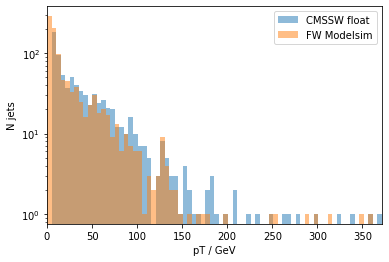

In [11]:
pt_lim = max(max(sim_pt), max(pt))
bins = np.linspace(0, pt_lim, 75)
w = bins[1] - bins[0]
h_sim, b = np.histogram(sim_pt, bins=bins)
h, b = np.histogram(pt, bins=bins)
plt.bar(bins[:-1]+w/2, h, width=w, label='CMSSW float', alpha=0.5)
plt.bar(bins[:-1]+w/2, h_sim, width=w, label='FW Modelsim', alpha=0.5)
plt.semilogy()
plt.xlabel('pT / GeV')
plt.ylabel('N jets')
plt.xlim((0, pt_lim))
plt.legend()
plt.savefig('pt.pdf')

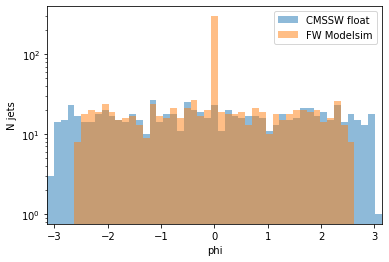

In [12]:
bins = np.linspace(-3.14, 3.14, 50)
w = bins[1] - bins[0]
h_sim, b = np.histogram(sim_phi, bins=bins)
h, b = np.histogram(phi, bins=bins)
plt.bar(bins[:-1]+w/2, h, width=w, label='CMSSW float', alpha=0.5)
plt.bar(bins[:-1]+w/2, h_sim, width=w, label='FW Modelsim', alpha=0.5)
plt.semilogy()
plt.xlabel('phi')
plt.ylabel('N jets')
plt.xlim((-3.14, 3.14))
plt.legend()
plt.savefig('phi.pdf')

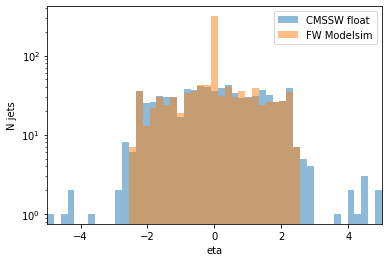

In [13]:
bins = np.linspace(-5, 5, 50)
w = bins[1] - bins[0]
h_sim, b = np.histogram(sim_eta, bins=bins)
h, b = np.histogram(eta, bins=bins)
plt.bar(bins[:-1]+w/2, h, width=w, label='CMSSW float', alpha=0.5)
plt.bar(bins[:-1]+w/2, h_sim, width=w, label='FW Modelsim', alpha=0.5)
plt.semilogy()
plt.xlabel('eta')
plt.ylabel('N jets')
plt.xlim((-5, 5))
plt.legend()
plt.savefig('eta.pdf')